# Introduction

## Prêt à mener la mission ?

Vous êtes consultant pour <a href="https://olist.com/">Olist</a>, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.


Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.


Vous venez de rejoindre Olist dans un contexte de recrutement intensif afin de monter leur équipe Data. En effet, ils font d’abord appel à des consultants comme vous en renfort sur les sujets les plus critiques en attendant d'internaliser les compétences. Avant de réaliser la segmentation client, on vous attribue une première mission pour aider Fernanda, Lead Data Analyst chez Olist. 


Après avoir étudié les éléments partagés par Fernanda vous vous mettez au travail.


------------------------

## Quelques jours plus tard
 

Cette urgence résolue, vous pouvez enfin passer à votre mission principale : Olist souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.


Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
 

Vous devrez fournir à l’équipe Marketing **une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


**<u>Les données</u>**

Pour cette mission, Olist vous fournit une <a href="https://course.oc-static.com/projects/olist.db">base de données</a> anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
 

Vous devez aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.
 

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.


------------------------
 
## 3 jours plus tard
 

Après quelques premières analyses, vous vous rendez compte qu'Olist ne vous a pas fourni beaucoup de données ; vous enquêtez donc auprès de l'entreprise pour obtenir quelques informations complémentaires, et vérifier que vous avez bien compris la mission.


Vous réalisez trois autres documents afin de préparer une réponse à Olist : 

- Un notebook avec des essais des différentes approches de modélisation 
- Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent 
- Une présentation pour un collègue afin d’obtenir ses retours sur votre approche
 

C’est parti pour cette dernière ligne droite ! 

# Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score

## Chargement de seaborn

In [2]:
sns.set()

# Lecture du dataset

In [3]:
# Read the dataset from the csv file made previously
df = pd.read_csv("data_cleaned.csv")

In [4]:
# Define a list with the features needed for the RFM segmentation
rfm_features = ["days_since_last_order", 
                "total_orders", "total_value", 
                "mean_review_score", 
                "order_purchase_timestamp",
               ]
# Make a copy of the original dataframe, with only the required features
rfm = df[rfm_features].copy()

In [5]:
# Print the head of the dataframe
rfm.head()

,days_since_last_order,total_orders,total_value,mean_review_score,order_purchase_timestamp
0,111,1,141.90,5.0,2018-05-10 10:56:27
1,114,1,27.19,4.0,2018-05-07 11:11:27
2,536,1,86.22,3.0,2017-03-10 21:05:03
3,320,1,43.62,4.0,2017-10-12 20:29:41
4,287,1,196.89,5.0,2017-11-14 19:45:42


Rappel de l'étendue des dates de notre dataset

In [6]:
# Print the oldest date in the dataframe
print(f"Date de commande la plus ancienne : {rfm["order_purchase_timestamp"].min()}")
# Print the newest date in the dataframe
print(f"Date de commande la plus récente : {rfm["order_purchase_timestamp"].max()}")

Date de commande la plus ancienne : 2016-09-15 12:16:38
Date de commande la plus récente : 2018-08-29 15:00:37


# Séparation des données en périodes temporelles

Afin d'évaluer la stabilité de notre clustering, nous allons découper notre jeu de données en période de temps équivalentes, puis appliquer le clustering à chacune des périodes et enfin comparer les différentes périodes à l'aide de l'ARI.

Tout d'abord séparons nos données. Pour cela, nous allons procéder à un découpage par tranche de 1 mois, en ne prenant en compte que les mois complets. Aussi nous collecterons les données dans plusieurs dataframes entre le mois d'Octobre 2016 et le mois de Juillet 2018, soit 22 mois.

Tout d'abord nous allons définir la date d'achat en index, puis trier l'index par ordre croissant.

In [7]:
# Set the index of the dataframe with the order_purchase_timestamp feature
rfm = rfm.set_index("order_purchase_timestamp").sort_index()

Puis nous opérons nos sélections de phase dans différents dataframes

In [8]:
# Define the number of month to study
number_of_month = 22
# Define the starting year
year = 2016
# Define the starting month
month = 9
# Create a list to store customers by period
rfm_phases_list = []

for i in range(0, number_of_month, 1):
    # Increment the month
    month += 1
    # If we are on the 12th month, we make a special calculation
    if month == 12:
        day = (date(year+1, 1, 1) - date(year, month, 1)).days
    # If the month is more than 12, we change of year, and make an appropriate calculation
    elif month > 12:
        month = 1
        year += 1
        day = (date(year, month, 1) - date(year-1, 12, 1)).days
    # Else, calculate the date of the start and end of the month
    else:
        day = (date(year, month+1, 1) - date(year, month, 1)).days

    # Store dates in variables
    start_date = date(year, month, 1)
    end_date = date(year, month, day)

    # Select customers based on the start and end date
    rfm_phase = rfm.loc[start_date.strftime("%Y-%m-%d"):end_date.strftime("%Y-%m-%d")]
    # Store everything in the list
    rfm_phases_list.append(rfm_phase)

Vérifions la taille de nos échantillons

In [9]:
# For each element in the list, print the number of individuals
for i in range(len(rfm_phases_list)):
    print(f"L'échantillon n°{i+1} contient {rfm_phases_list[i].shape[0]} individus")

L'échantillon n°1 contient 262 individus
L'échantillon n°2 contient 0 individus
L'échantillon n°3 contient 1 individus
L'échantillon n°4 contient 656 individus
L'échantillon n°5 contient 1575 individus
L'échantillon n°6 contient 2434 individus
L'échantillon n°7 contient 2190 individus
L'échantillon n°8 contient 3335 individus
L'échantillon n°9 contient 2945 individus
L'échantillon n°10 contient 3616 individus
L'échantillon n°11 contient 3917 individus
L'échantillon n°12 contient 3901 individus
L'échantillon n°13 contient 4177 individus
L'échantillon n°14 contient 6811 individus
L'échantillon n°15 contient 5268 individus
L'échantillon n°16 contient 6599 individus
L'échantillon n°17 contient 5993 individus
L'échantillon n°18 contient 6620 individus
L'échantillon n°19 contient 6355 individus
L'échantillon n°20 contient 6379 individus
L'échantillon n°21 contient 5760 individus
L'échantillon n°22 contient 5644 individus


La taille des échantillons varie énormément, notamment pour les 5 premiers mois qui comportent très peu, voir aucun, échantillons.

Afin de fiabiliser notre étude, nous n'allons sélectionner que les échantillons entre 8 et 22.

In [10]:
# Delete the first elements of the list not containing enough customers
del rfm_phases_list[0:7]

A présent que nous avons définis nos dataframes selon les différentes périodes, la variable order_purchase_timestamp ne nous est plus nécessaire.

Supprimons la.

In [11]:
# For each dataframe, reset index and suppress the order_purchase_timestamp feature
for i in range(len(rfm_phases_list)):
    rfm_phases_list[i] = rfm_phases_list[i].reset_index()
    rfm_phases_list[i] = rfm_phases_list[i].drop("order_purchase_timestamp", axis=1)

# Préparation du modèle

Pour l'entrainement de notre modèle, nous allons définir un pipeline avec les transformations et normalisations effectuées sur nos variables puis notre modèle.

Tout d'abord définissons un premier pipeline pour la normalisation.

In [12]:
# Select feature where we will apply a log transformation
to_log_features = ["total_orders", "total_value",]
# Create a pipeline to apply the log transformation and StandardScaler
to_log_transformer = Pipeline(
    steps = [("log", FunctionTransformer(np.log1p, validate=False)),
            ("scaler", StandardScaler())]
)

# Select other features
other_features = ["days_since_last_order", "mean_review_score"]
# Create a pipeline to apply the StandardScaler
other_transformer = Pipeline(
    steps = [("scaler", StandardScaler())]
)

Nous définissons ensuite un préprocesseur qui appliquera les différentes transformations

In [13]:
# Create a ColumnTransformer that will use both the log pipeline and the standard pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ("to_log", to_log_transformer, to_log_features),
        ("others", other_transformer, other_features)
    ]
)

Enfin nous définissons le pipeline avec le préprocesseur et le modèle

In [14]:
# Define a pipeline with the preprocessor and the KMeans model
kmeans = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("kmeans", KMeans(n_clusters=5, random_state=8))
    ]
)

# Calcul de l'Adjusted Rand Score

Nous allons à présent comparer les score ARI de nos modèles selon les différentes périodes.

Pour cela, nous allons tout d'abord entrainer un kmeans pour la première période de notre jeu de données. Puis nous entrainerons de nouveau modèles pour chacune des autres périodes et compareront les prédictions des différents modèles à l'aide de l'ARI score.

A présent, nous allons pour chacun des autres dataframes entrainer un nouveau modèle, puis nous effectuerons les prédictions à l'aide du nouveau modèle et du modèle de la phase 1.

Les prédictions des deux modèles serviront à calculer le score ARI.

In [15]:
# Create a list to store ari scores
ari_scores = []
# Train the KMeans with the data of initial phase
initial_kmeans = kmeans.fit(rfm_phases_list[0])
for i in range(len(rfm_phases_list)):
    # Make the predictions with the initial model
    initial_pred = initial_kmeans.predict(rfm_phases_list[i])
    # Train the KMeans and make the predictions with the new model
    new_pred = kmeans.fit_predict(rfm_phases_list[i])

    # Calculate the ARI score and store it in the list
    ari_scores.append(adjusted_rand_score(
        new_pred,
        initial_pred,
    ))

ari_scores = pd.DataFrame(ari_scores, columns=["Score"])

Affichons les scores sous la forme d'une courbe

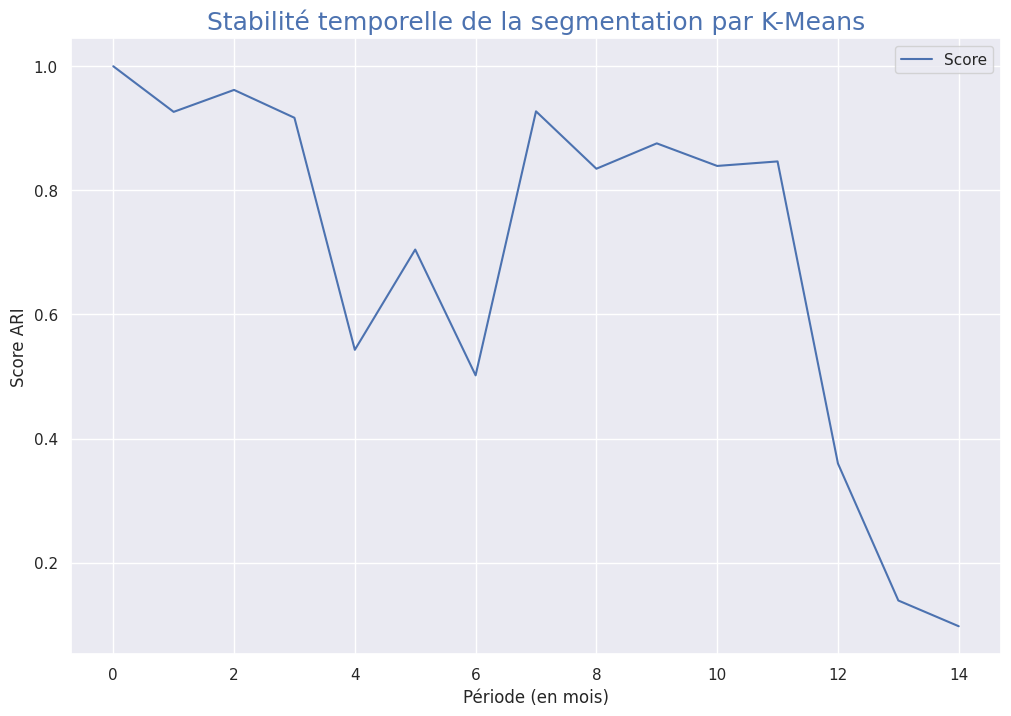

In [16]:
# Plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_scores)
plt.xlabel("Période (en mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

On remarque une nette diminution de l'ARI après 3 mois, aussi il sera conseillé de réentrainer le modèle passé ce délais.